In [8]:
from tqdm import tqdm
import joblib
from collections import Counter

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from utils import get_DF, get_indices

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score, classification_report, accuracy_score,\
                                confusion_matrix, plot_roc_curve, roc_auc_score, recall_score, precision_score

In [2]:
df = get_DF()

tfidf = joblib.load(f'vectors/tfidf_0.15.pkl')
mat = pd.read_csv("vectors/svd_mat_0.15.tsv", delimiter="\t", header=None).to_numpy()
scaled = StandardScaler(with_mean=False).fit_transform(mat)

tfidf_words = tfidf.get_feature_names()
mat_inds = get_indices(df.target.unique(), tfidf_words)
df["mat_ind"] = df.target.apply(lambda w: mat_inds[w] if w in mat_inds else -1)
df = df[df.mat_ind > -1]

100%|██████████| 91/91 [00:00<00:00, 104.46it/s]


In [3]:
target_annotations = {x:list(subdf.y) for x, subdf in df.groupby(["annotator_x", "target"])}
xs, y = list(zip(*target_annotations.items()))
x_anno, x_target = list(zip(*xs))

mldf = pd.DataFrame([x_anno, x_target, y]).T
mldf.columns = ["x_anno", "target", "y_ls"]

mldf["ratio"] = mldf.y_ls.apply(lambda ls: sum(ls)/len(ls))
# mldf = mldf[mldf.ratio != 0.5]
mldf["maj_vote"] = mldf.ratio.apply(lambda r: int(r > 0.5))

mldf = pd.concat([mldf, pd.get_dummies(mldf["x_anno"])], axis=1)

---

In [4]:
anno_prior = {}

for a, subdf in mldf.groupby("x_anno"):
    ys = [y for ls in subdf.y_ls for y in ls]    
    anno_prior[a] = sum(ys)/len(ys)

In [9]:
accs = []
bal_accs = []
precs = []
recalls = []
aucs = []



for _ in tqdm(range(100)):
    words_shuffled = np.random.permutation(mldf.target.unique())

    ratio = int(mldf.target.unique().shape[0]*0.8)
    train_words = set(words_shuffled[:ratio])
    msk = mldf.target.isin(train_words)

    # msk = np.random.rand(len(mldf)) < 0.7

    train_df = mldf[msk]
    test_df = mldf[~msk]


    target_train, anno_train, Y_train = (np.stack(train_df.target.apply(lambda w: scaled[mat_inds[w]])), 
                                         train_df.iloc[:, 5:].to_numpy(), 
                                         train_df.maj_vote.to_numpy())

    target_test, anno_test, Y_test = (np.stack(test_df.target.apply(lambda w: scaled[mat_inds[w]])),
                                        test_df.iloc[:, 5:].to_numpy(),
                                        test_df.maj_vote.to_numpy())

    X_train, X_test = np.hstack([target_train, anno_train]), np.hstack([target_test, anno_test])
    
    



    baseline_preds = test_df.x_anno.apply(lambda a: int(anno_prior[a] > 0.5))


    print(classification_report(Y_test, baseline_preds))
    b = balanced_accuracy_score(Y_test, baseline_preds)
    a = accuracy_score(Y_test, baseline_preds)
    bal_accs.append(b)
    accs.append(a)

    precs.append(precision_score(Y_test, baseline_preds))
    recalls.append(recall_score(Y_test, baseline_preds))
    aucs.append(roc_auc_score(Y_test, baseline_preds))

    cm = confusion_matrix(Y_test, baseline_preds)

    print(cm)

  2%|▏         | 2/100 [00:00<00:08, 11.27it/s]

              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1200
           1       0.65      0.10      0.17       877

    accuracy                           0.60      2077
   macro avg       0.62      0.53      0.45      2077
weighted avg       0.62      0.60      0.50      2077

[[1155   45]
 [ 792   85]]
              precision    recall  f1-score   support

           0       0.68      0.95      0.80      1245
           1       0.56      0.12      0.19       620

    accuracy                           0.68      1865
   macro avg       0.62      0.54      0.50      1865
weighted avg       0.64      0.68      0.60      1865

[[1188   57]
 [ 547   73]]
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      1325
           1       0.71      0.11      0.18       954

    accuracy                           0.61      2279
   macro avg       0.66      0.54      0.46      2279
weighted avg       0

  6%|▌         | 6/100 [00:00<00:07, 13.26it/s]

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1386
           1       0.66      0.22      0.33       361

    accuracy                           0.82      1747
   macro avg       0.75      0.59      0.61      1747
weighted avg       0.79      0.82      0.78      1747

[[1346   40]
 [ 282   79]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1585
           1       0.56      0.14      0.23       552

    accuracy                           0.75      2137
   macro avg       0.66      0.55      0.54      2137
weighted avg       0.71      0.75      0.69      2137

[[1522   63]
 [ 473   79]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1489
           1       0.57      0.12      0.19       637

    accuracy                           0.71      2126
   macro avg       0.65      0.54      0.51      2126
weighted avg       0

 10%|█         | 10/100 [00:00<00:06, 14.53it/s]

[[1374   61]
 [1051  103]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1684
           1       0.44      0.15      0.23       348

    accuracy                           0.82      2032
   macro avg       0.64      0.56      0.56      2032
weighted avg       0.78      0.82      0.78      2032

[[1617   67]
 [ 295   53]]
              precision    recall  f1-score   support

           0       0.54      0.96      0.70      1233
           1       0.68      0.09      0.16      1093

    accuracy                           0.55      2326
   macro avg       0.61      0.53      0.43      2326
weighted avg       0.61      0.55      0.44      2326

[[1187   46]
 [ 995   98]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1811
           1       0.54      0.20      0.29       378

    accuracy                           0.83      2189
   macro avg       0.69      0.58      0.60    

 12%|█▏        | 12/100 [00:00<00:05, 14.73it/s]

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1410
           1       0.57      0.14      0.23       460

    accuracy                           0.76      1870
   macro avg       0.67      0.55      0.54      1870
weighted avg       0.73      0.76      0.70      1870

[[1361   49]
 [ 394   66]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1616
           1       0.54      0.14      0.22       535

    accuracy                           0.76      2151
   macro avg       0.66      0.55      0.54      2151
weighted avg       0.71      0.76      0.70      2151

[[1553   63]
 [ 461   74]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      1097
           1       0.64      0.12      0.21       522

    accuracy                           0.70      1619
   macro avg       0.67      0.55      0.51      1619
weighted avg       0

 16%|█▌        | 16/100 [00:01<00:07, 11.78it/s]

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1283
           1       0.57      0.14      0.23       487

    accuracy                           0.74      1770
   macro avg       0.66      0.55      0.53      1770
weighted avg       0.70      0.74      0.67      1770

[[1232   51]
 [ 418   69]]
              precision    recall  f1-score   support

           0       0.61      0.96      0.74      1057
           1       0.63      0.09      0.16       728

    accuracy                           0.61      1785
   macro avg       0.62      0.53      0.45      1785
weighted avg       0.62      0.61      0.51      1785

[[1018   39]
 [ 662   66]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1371
           1       0.52      0.19      0.28       305

    accuracy                           0.82      1676
   macro avg       0.68      0.58      0.59      1676
weighted avg       0

 18%|█▊        | 18/100 [00:01<00:06, 11.72it/s]

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2043
           1       0.48      0.20      0.28       365

    accuracy                           0.85      2408
   macro avg       0.67      0.58      0.60      2408
weighted avg       0.81      0.85      0.82      2408

[[1962   81]
 [ 291   74]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1653
           1       0.58      0.13      0.21       644

    accuracy                           0.73      2297
   macro avg       0.66      0.55      0.52      2297
weighted avg       0.69      0.73      0.66      2297

[[1592   61]
 [ 561   83]]
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       959
           1       0.70      0.11      0.19       552

    accuracy                           0.66      1511
   macro avg       0.68      0.54      0.48      1511
weighted avg       0

 20%|██        | 20/100 [00:01<00:06, 11.45it/s]

              precision    recall  f1-score   support

           0       0.75      0.97      0.84      1278
           1       0.59      0.12      0.20       471

    accuracy                           0.74      1749
   macro avg       0.67      0.55      0.52      1749
weighted avg       0.71      0.74      0.67      1749

[[1237   41]
 [ 413   58]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1896
           1       0.59      0.19      0.28       463

    accuracy                           0.82      2359
   macro avg       0.71      0.58      0.59      2359
weighted avg       0.78      0.82      0.77      2359

[[1837   59]
 [ 377   86]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1763
           1       0.57      0.12      0.20       764

    accuracy                           0.71      2527
   macro avg       0.64      0.54      0.51      2527
weighted avg       0

 24%|██▍       | 24/100 [00:01<00:06, 11.26it/s]

[[1693   70]
 [ 673   91]]
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1293
           1       0.64      0.14      0.24       519

    accuracy                           0.73      1812
   macro avg       0.69      0.56      0.54      1812
weighted avg       0.71      0.73      0.66      1812

[[1250   43]
 [ 444   75]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1437
           1       0.54      0.16      0.25       408

    accuracy                           0.78      1845
   macro avg       0.67      0.56      0.56      1845
weighted avg       0.75      0.78      0.74      1845

[[1381   56]
 [ 341   67]]


 26%|██▌       | 26/100 [00:02<00:06, 11.53it/s]

              precision    recall  f1-score   support

           0       0.54      0.96      0.69      1015
           1       0.65      0.08      0.15       901

    accuracy                           0.55      1916
   macro avg       0.60      0.52      0.42      1916
weighted avg       0.59      0.55      0.44      1916

[[975  40]
 [826  75]]
              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1487
           1       0.60      0.11      0.18       834

    accuracy                           0.65      2321
   macro avg       0.63      0.53      0.48      2321
weighted avg       0.64      0.65      0.56      2321

[[1428   59]
 [ 746   88]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.80      1277
           1       0.64      0.12      0.21       633

    accuracy                           0.69      1910
   macro avg       0.66      0.54      0.51      1910
weighted avg       0.67 

 30%|███       | 30/100 [00:02<00:05, 12.55it/s]

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1382
           1       0.67      0.15      0.25       480

    accuracy                           0.76      1862
   macro avg       0.72      0.56      0.55      1862
weighted avg       0.74      0.76      0.70      1862

[[1346   36]
 [ 407   73]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1682
           1       0.59      0.13      0.21       727

    accuracy                           0.71      2409
   macro avg       0.66      0.54      0.52      2409
weighted avg       0.68      0.71      0.64      2409

[[1618   64]
 [ 634   93]]
              precision    recall  f1-score   support

           0       0.66      0.96      0.79      1410
           1       0.59      0.10      0.17       766

    accuracy                           0.66      2176
   macro avg       0.63      0.53      0.48      2176
weighted avg       0

 32%|███▏      | 32/100 [00:02<00:05, 12.17it/s]

              precision    recall  f1-score   support

           0       0.68      0.96      0.80      1790
           1       0.59      0.11      0.18       909

    accuracy                           0.67      2699
   macro avg       0.63      0.54      0.49      2699
weighted avg       0.65      0.67      0.59      2699

[[1721   69]
 [ 810   99]]
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1227
           1       0.63      0.13      0.21       477

    accuracy                           0.73      1704
   macro avg       0.68      0.55      0.53      1704
weighted avg       0.71      0.73      0.66      1704

[[1191   36]
 [ 416   61]]
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1461
           1       0.59      0.09      0.15      1048

    accuracy                           0.59      2509
   macro avg       0.59      0.52      0.44      2509
weighted avg       0

 36%|███▌      | 36/100 [00:02<00:04, 13.01it/s]

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1494
           1       0.63      0.13      0.22       682

    accuracy                           0.70      2176
   macro avg       0.67      0.55      0.52      2176
weighted avg       0.68      0.70      0.63      2176

[[1441   53]
 [ 591   91]]
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1715
           1       0.50      0.11      0.18       693

    accuracy                           0.71      2408
   macro avg       0.61      0.53      0.50      2408
weighted avg       0.66      0.71      0.64      2408

[[1639   76]
 [ 617   76]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1368
           1       0.59      0.17      0.26       407

    accuracy                           0.78      1775
   macro avg       0.69      0.57      0.57      1775
weighted avg       0

 40%|████      | 40/100 [00:03<00:04, 13.82it/s]

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1203
           1       0.69      0.14      0.23       549

    accuracy                           0.71      1752
   macro avg       0.70      0.56      0.53      1752
weighted avg       0.71      0.71      0.64      1752

[[1169   34]
 [ 472   77]]
              precision    recall  f1-score   support

           0       0.42      0.97      0.59       796
           1       0.79      0.08      0.15      1149

    accuracy                           0.44      1945
   macro avg       0.61      0.53      0.37      1945
weighted avg       0.64      0.44      0.33      1945

[[ 771   25]
 [1055   94]]
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       998
           1       0.74      0.14      0.23       566

    accuracy                           0.67      1564
   macro avg       0.70      0.55      0.51      1564
weighted avg       0

 42%|████▏     | 42/100 [00:03<00:04, 12.86it/s]

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1302
           1       0.56      0.16      0.25       401

    accuracy                           0.77      1703
   macro avg       0.67      0.56      0.56      1703
weighted avg       0.73      0.77      0.72      1703

[[1252   50]
 [ 338   63]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1349
           1       0.65      0.17      0.27       445

    accuracy                           0.77      1794
   macro avg       0.71      0.57      0.57      1794
weighted avg       0.75      0.77      0.72      1794

[[1308   41]
 [ 369   76]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1948
           1       0.50      0.13      0.21       643

    accuracy                           0.75      2591
   macro avg       0.63      0.54      0.53      2591
weighted avg       0

 46%|████▌     | 46/100 [00:03<00:04, 12.93it/s]

              precision    recall  f1-score   support

           0       0.58      0.96      0.72      1106
           1       0.66      0.09      0.16       856

    accuracy                           0.58      1962
   macro avg       0.62      0.53      0.44      1962
weighted avg       0.61      0.58      0.48      1962

[[1065   41]
 [ 777   79]]
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1125
           1       0.56      0.13      0.21       461

    accuracy                           0.72      1586
   macro avg       0.65      0.54      0.52      1586
weighted avg       0.68      0.72      0.65      1586

[[1080   45]
 [ 403   58]]
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1045
           1       0.58      0.11      0.18       493

    accuracy                           0.69      1538
   macro avg       0.64      0.54      0.49      1538
weighted avg       0

 48%|████▊     | 48/100 [00:03<00:03, 13.07it/s]

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      1555
           1       0.53      0.11      0.19       561

    accuracy                           0.74      2116
   macro avg       0.64      0.54      0.51      2116
weighted avg       0.69      0.74      0.67      2116

[[1500   55]
 [ 498   63]]
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1821
           1       0.58      0.13      0.21       735

    accuracy                           0.72      2556
   macro avg       0.66      0.55      0.52      2556
weighted avg       0.69      0.72      0.65      2556

[[1753   68]
 [ 641   94]]
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1132
           1       0.59      0.13      0.21       396

    accuracy                           0.75      1528
   macro avg       0.67      0.55      0.53      1528
weighted avg       0

 52%|█████▏    | 52/100 [00:04<00:03, 12.67it/s]

              precision    recall  f1-score   support

           0       0.59      0.97      0.74       950
           1       0.73      0.11      0.19       704

    accuracy                           0.60      1654
   macro avg       0.66      0.54      0.46      1654
weighted avg       0.65      0.60      0.50      1654

[[922  28]
 [629  75]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1783
           1       0.53      0.14      0.22       541

    accuracy                           0.77      2324
   macro avg       0.66      0.55      0.55      2324
weighted avg       0.73      0.77      0.72      2324

[[1716   67]
 [ 464   77]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1608
           1       0.45      0.17      0.25       320

    accuracy                           0.83      1928
   macro avg       0.65      0.56      0.57      1928
weighted avg       0.79 

 56%|█████▌    | 56/100 [00:04<00:03, 13.92it/s]

              precision    recall  f1-score   support

           0       0.55      0.96      0.70      1191
           1       0.71      0.10      0.18      1040

    accuracy                           0.56      2231
   macro avg       0.63      0.53      0.44      2231
weighted avg       0.63      0.56      0.46      2231

[[1148   43]
 [ 934  106]]
              precision    recall  f1-score   support

           0       0.68      0.96      0.80      1363
           1       0.59      0.11      0.19       680

    accuracy                           0.68      2043
   macro avg       0.64      0.54      0.49      2043
weighted avg       0.65      0.68      0.60      2043

[[1310   53]
 [ 603   77]]
              precision    recall  f1-score   support

           0       0.68      0.96      0.80      1176
           1       0.58      0.12      0.20       589

    accuracy                           0.68      1765
   macro avg       0.63      0.54      0.50      1765
weighted avg       0

 60%|██████    | 60/100 [00:04<00:02, 14.78it/s]

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1669
           1       0.47      0.18      0.26       319

    accuracy                           0.84      1988
   macro avg       0.67      0.57      0.58      1988
weighted avg       0.80      0.84      0.80      1988

[[1605   64]
 [ 262   57]]
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1678
           1       0.58      0.09      0.16      1003

    accuracy                           0.64      2681
   macro avg       0.61      0.53      0.46      2681
weighted avg       0.62      0.64      0.54      2681

[[1610   68]
 [ 909   94]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1782
           1       0.52      0.22      0.31       320

    accuracy                           0.85      2102
   macro avg       0.70      0.59      0.61      2102
weighted avg       0

 62%|██████▏   | 62/100 [00:04<00:02, 14.52it/s]

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1511
           1       0.51      0.15      0.23       382

    accuracy                           0.80      1893
   macro avg       0.66      0.56      0.56      1893
weighted avg       0.75      0.80      0.75      1893

[[1457   54]
 [ 326   56]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.82      1052
           1       0.72      0.15      0.25       506

    accuracy                           0.71      1558
   macro avg       0.71      0.56      0.53      1558
weighted avg       0.71      0.71      0.63      1558

[[1022   30]
 [ 429   77]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      1720
           1       0.62      0.14      0.23       637

    accuracy                           0.74      2357
   macro avg       0.69      0.55      0.54      2357
weighted avg       0

 68%|██████▊   | 68/100 [00:05<00:02, 15.40it/s]

[[1148   43]
 [ 559   73]]
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1202
           1       0.61      0.12      0.20       456

    accuracy                           0.74      1658
   macro avg       0.68      0.54      0.52      1658
weighted avg       0.71      0.74      0.67      1658

[[1167   35]
 [ 402   54]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1831
           1       0.51      0.16      0.24       456

    accuracy                           0.80      2287
   macro avg       0.67      0.56      0.56      2287
weighted avg       0.76      0.80      0.76      2287

[[1763   68]
 [ 384   72]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1633
           1       0.49      0.15      0.23       425

    accuracy                           0.79      2058
   macro avg       0.65      0.55      0.55    

 72%|███████▏  | 72/100 [00:05<00:01, 14.85it/s]

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1405
           1       0.56      0.12      0.20       551

    accuracy                           0.73      1956
   macro avg       0.65      0.54      0.52      1956
weighted avg       0.69      0.73      0.66      1956

[[1352   53]
 [ 484   67]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1330
           1       0.58      0.11      0.19       660

    accuracy                           0.68      1990
   macro avg       0.63      0.54      0.49      1990
weighted avg       0.65      0.68      0.60      1990

[[1277   53]
 [ 587   73]]
              precision    recall  f1-score   support

           0       0.75      0.96      0.85      1296
           1       0.58      0.14      0.22       476

    accuracy                           0.74      1772
   macro avg       0.67      0.55      0.53      1772
weighted avg       0

 76%|███████▌  | 76/100 [00:05<00:01, 15.42it/s]

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      2432
           1       0.51      0.15      0.23       719

    accuracy                           0.77      3151
   macro avg       0.65      0.55      0.55      3151
weighted avg       0.73      0.77      0.72      3151

[[2329  103]
 [ 612  107]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1421
           1       0.53      0.13      0.21       482

    accuracy                           0.75      1903
   macro avg       0.65      0.55      0.53      1903
weighted avg       0.71      0.75      0.69      1903

[[1364   57]
 [ 418   64]]
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1368
           1       0.60      0.10      0.18       819

    accuracy                           0.64      2187
   macro avg       0.62      0.53      0.47      2187
weighted avg       0

 80%|████████  | 80/100 [00:05<00:01, 14.93it/s]

              precision    recall  f1-score   support

           0       0.61      0.96      0.75       936
           1       0.69      0.11      0.20       650

    accuracy                           0.62      1586
   macro avg       0.65      0.54      0.47      1586
weighted avg       0.64      0.62      0.52      1586

[[903  33]
 [576  74]]
              precision    recall  f1-score   support

           0       0.45      0.96      0.61       971
           1       0.73      0.08      0.14      1257

    accuracy                           0.46      2228
   macro avg       0.59      0.52      0.38      2228
weighted avg       0.60      0.46      0.35      2228

[[ 934   37]
 [1159   98]]
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1525
           1       0.60      0.16      0.25       411

    accuracy                           0.80      1936
   macro avg       0.70      0.56      0.57      1936
weighted avg       0.77 

 82%|████████▏ | 82/100 [00:06<00:01, 15.30it/s]

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      1179
           1       0.67      0.13      0.22       618

    accuracy                           0.68      1797
   macro avg       0.68      0.55      0.51      1797
weighted avg       0.68      0.68      0.60      1797

[[1139   40]
 [ 536   82]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      2044
           1       0.46      0.14      0.22       508

    accuracy                           0.80      2552
   macro avg       0.64      0.55      0.55      2552
weighted avg       0.75      0.80      0.75      2552

[[1959   85]
 [ 435   73]]
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1205
           1       0.65      0.12      0.20       497

    accuracy                           0.72      1702
   macro avg       0.69      0.55      0.52      1702
weighted avg       0

 86%|████████▌ | 86/100 [00:06<00:01, 12.43it/s]

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1527
           1       0.64      0.19      0.29       444

    accuracy                           0.79      1971
   macro avg       0.72      0.58      0.58      1971
weighted avg       0.77      0.79      0.75      1971

[[1481   46]
 [ 361   83]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1687
           1       0.61      0.17      0.27       495

    accuracy                           0.79      2182
   macro avg       0.71      0.57      0.57      2182
weighted avg       0.76      0.79      0.74      2182

[[1633   54]
 [ 410   85]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.80      1258
           1       0.63      0.12      0.20       623

    accuracy                           0.68      1881
   macro avg       0.66      0.54      0.50      1881
weighted avg       0

 90%|█████████ | 90/100 [00:06<00:00, 14.18it/s]

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1288
           1       0.65      0.14      0.23       506

    accuracy                           0.74      1794
   macro avg       0.69      0.56      0.54      1794
weighted avg       0.71      0.74      0.67      1794

[[1249   39]
 [ 435   71]]
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1339
           1       0.63      0.16      0.25       463

    accuracy                           0.76      1802
   macro avg       0.70      0.56      0.56      1802
weighted avg       0.73      0.76      0.70      1802

[[1295   44]
 [ 389   74]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1734
           1       0.48      0.19      0.27       329

    accuracy                           0.84      2063
   macro avg       0.67      0.58      0.59      2063
weighted avg       0

 94%|█████████▍| 94/100 [00:06<00:00, 15.24it/s]

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1330
           1       0.52      0.14      0.22       415

    accuracy                           0.77      1745
   macro avg       0.65      0.55      0.54      1745
weighted avg       0.72      0.77      0.71      1745

[[1276   54]
 [ 356   59]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       905
           1       0.63      0.15      0.25       336

    accuracy                           0.75      1241
   macro avg       0.69      0.56      0.55      1241
weighted avg       0.72      0.75      0.69      1241

[[875  30]
 [284  52]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1911
           1       0.51      0.19      0.28       421

    accuracy                           0.82      2332
   macro avg       0.67      0.58      0.59      2332
weighted avg       0.78 

 98%|█████████▊| 98/100 [00:07<00:00, 15.88it/s]

              precision    recall  f1-score   support

           0       0.67      0.97      0.80      1260
           1       0.66      0.12      0.20       668

    accuracy                           0.67      1928
   macro avg       0.67      0.54      0.50      1928
weighted avg       0.67      0.67      0.59      1928

[[1220   40]
 [ 589   79]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2278
           1       0.52      0.15      0.23       651

    accuracy                           0.78      2929
   macro avg       0.66      0.55      0.55      2929
weighted avg       0.74      0.78      0.73      2929

[[2192   86]
 [ 556   95]]
              precision    recall  f1-score   support

           0       0.62      0.97      0.75       941
           1       0.68      0.10      0.18       632

    accuracy                           0.62      1573
   macro avg       0.65      0.53      0.46      1573
weighted avg       0

100%|██████████| 100/100 [00:07<00:00, 13.61it/s]

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1759
           1       0.53      0.13      0.21       610

    accuracy                           0.75      2369
   macro avg       0.64      0.54      0.53      2369
weighted avg       0.70      0.75      0.68      2369

[[1688   71]
 [ 531   79]]
              precision    recall  f1-score   support

           0       0.60      0.97      0.74       902
           1       0.70      0.11      0.19       643

    accuracy                           0.61      1545
   macro avg       0.65      0.54      0.47      1545
weighted avg       0.65      0.61      0.51      1545

[[872  30]
 [572  71]]


/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


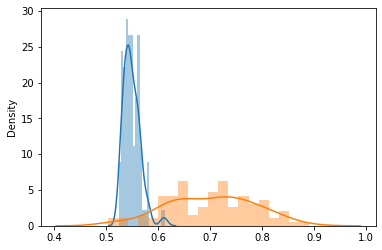

In [18]:
_=sns.distplot(bal_accs, bins=20)
_=sns.distplot(accs, bins=20)

In [10]:
import numpy as np, scipy.stats as st


print("balanced acc:", st.t.interval(0.95, len(bal_accs)-1, loc=np.mean(bal_accs), scale=st.sem(bal_accs)))
print("accuracy    :", st.t.interval(0.95, len(accs)-1, loc=np.mean(accs), scale=st.sem(accs)))
print("recall    :", st.t.interval(0.95, len(recalls)-1, loc=np.mean(recalls), scale=st.sem(recalls)))
print("precision    :", st.t.interval(0.95, len(precs)-1, loc=np.mean(precs), scale=st.sem(precs)))
print("AUC    :", st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs)))


balanced acc: (0.5458557149660525, 0.5519972322308863)
accuracy    : (0.7001496241429216, 0.7326015672350511)
recall    : (0.12784732291329973, 0.13980135778743566)
precision    : (0.58067287436707, 0.6096635266992999)
AUC    : (0.5458557149660525, 0.5519972322308863)


---

## Stupid Baseline

In [24]:
prior = df.y.sum()/df.shape[0]


accs = []
bal_accs = []

for _ in tqdm(range(100)):
    words_shuffled = np.random.permutation(mldf.target.unique())

    ratio = int(mldf.target.unique().shape[0]*0.8)
    train_words = set(words_shuffled[:ratio])
    msk = mldf.target.isin(train_words)

    # msk = np.random.rand(len(mldf)) < 0.7

    train_df = mldf[msk]
    test_df = mldf[~msk]


    target_train, anno_train, Y_train = (np.stack(train_df.target.apply(lambda w: scaled[mat_inds[w]])), 
                                         train_df.iloc[:, 5:].to_numpy(), 
                                         train_df.maj_vote.to_numpy())

    target_test, anno_test, Y_test = (np.stack(test_df.target.apply(lambda w: scaled[mat_inds[w]])),
                                        test_df.iloc[:, 5:].to_numpy(),
                                        test_df.maj_vote.to_numpy())

    X_train, X_test = np.hstack([target_train, anno_train]), np.hstack([target_test, anno_test])
    
    



#     baseline_preds = np.zeros_like(Y_test)
    baseline_preds = np.random.choice(2, size=Y_test.shape, p=[1-prior, prior])


    print(classification_report(Y_test, baseline_preds))
    b = balanced_accuracy_score(Y_test, baseline_preds)
    a = accuracy_score(Y_test, baseline_preds)
    bal_accs.append(b)
    accs.append(a)


    cm = confusion_matrix(Y_test, baseline_preds)

    print(cm)


  3%|▎         | 3/100 [00:00<00:09, 10.42it/s]

              precision    recall  f1-score   support

           0       0.64      0.73      0.69      1250
           1       0.36      0.26      0.30       695

    accuracy                           0.57      1945
   macro avg       0.50      0.50      0.49      1945
weighted avg       0.54      0.57      0.55      1945

[[918 332]
 [511 184]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1696
           1       0.21      0.26      0.23       442

    accuracy                           0.64      2138
   macro avg       0.50      0.50      0.50      2138
weighted avg       0.67      0.64      0.66      2138

[[1254  442]
 [ 326  116]]
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1469
           1       0.23      0.27      0.25       419

    accuracy                           0.63      1888
   macro avg       0.50      0.50      0.50      1888
weighted avg       0.66 

  5%|▌         | 5/100 [00:00<00:08, 10.77it/s]

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1681
           1       0.15      0.26      0.19       343

    accuracy                           0.64      2024
   macro avg       0.49      0.48      0.48      2024
weighted avg       0.71      0.64      0.67      2024

[[1198  483]
 [ 255   88]]
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      1070
           1       0.37      0.27      0.31       592

    accuracy                           0.58      1662
   macro avg       0.51      0.51      0.51      1662
weighted avg       0.55      0.58      0.56      1662

[[800 270]
 [431 161]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.66      1269
           1       0.39      0.25      0.31       850

    accuracy                           0.54      2119
   macro avg       0.49      0.49      0.48      2119
weighted avg       0.51 

  8%|▊         | 8/100 [00:00<00:09,  9.48it/s]

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1264
           1       0.29      0.28      0.28       505

    accuracy                           0.60      1769
   macro avg       0.50      0.50      0.50      1769
weighted avg       0.60      0.60      0.60      1769

[[925 339]
 [365 140]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1528
           1       0.25      0.24      0.25       542

    accuracy                           0.61      2070
   macro avg       0.49      0.49      0.49      2070
weighted avg       0.61      0.61      0.61      2070

[[1133  395]
 [ 410  132]]


 10%|█         | 10/100 [00:01<00:10,  8.34it/s]

              precision    recall  f1-score   support

           0       0.81      0.73      0.76      1922
           1       0.18      0.26      0.21       454

    accuracy                           0.64      2376
   macro avg       0.49      0.49      0.49      2376
weighted avg       0.69      0.64      0.66      2376

[[1399  523]
 [ 337  117]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.68      1074
           1       0.35      0.27      0.31       586

    accuracy                           0.57      1660
   macro avg       0.50      0.50      0.50      1660
weighted avg       0.54      0.57      0.55      1660

[[779 295]
 [425 161]]


 11%|█         | 11/100 [00:01<00:10,  8.34it/s]

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1947
           1       0.18      0.23      0.20       487

    accuracy                           0.63      2434
   macro avg       0.48      0.48      0.48      2434
weighted avg       0.67      0.63      0.65      2434

[[1423  524]
 [ 374  113]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1378
           1       0.25      0.26      0.25       468

    accuracy                           0.62      1846
   macro avg       0.50      0.50      0.50      1846
weighted avg       0.62      0.62      0.62      1846

[[1018  360]
 [ 348  120]]


 14%|█▍        | 14/100 [00:01<00:09,  8.81it/s]

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1355
           1       0.28      0.28      0.28       493

    accuracy                           0.61      1848
   macro avg       0.51      0.51      0.51      1848
weighted avg       0.62      0.61      0.61      1848

[[994 361]
 [353 140]]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1311
           1       0.28      0.24      0.26       575

    accuracy                           0.58      1886
   macro avg       0.48      0.48      0.48      1886
weighted avg       0.56      0.58      0.57      1886

[[946 365]
 [436 139]]


 16%|█▌        | 16/100 [00:01<00:08,  9.43it/s]

              precision    recall  f1-score   support

           0       0.64      0.71      0.68       999
           1       0.35      0.27      0.31       554

    accuracy                           0.56      1553
   macro avg       0.49      0.49      0.49      1553
weighted avg       0.54      0.56      0.54      1553

[[714 285]
 [402 152]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2050
           1       0.26      0.24      0.25       821

    accuracy                           0.59      2871
   macro avg       0.48      0.48      0.48      2871
weighted avg       0.58      0.59      0.58      2871

[[1488  562]
 [ 622  199]]


 19%|█▉        | 19/100 [00:02<00:08,  9.57it/s]

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1684
           1       0.31      0.27      0.29       708

    accuracy                           0.61      2392
   macro avg       0.51      0.51      0.51      2392
weighted avg       0.59      0.61      0.60      2392

[[1269  415]
 [ 519  189]]
              precision    recall  f1-score   support

           0       0.59      0.73      0.65      1152
           1       0.39      0.25      0.31       793

    accuracy                           0.54      1945
   macro avg       0.49      0.49      0.48      1945
weighted avg       0.51      0.54      0.51      1945

[[845 307]
 [595 198]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1672
           1       0.24      0.29      0.26       502

    accuracy                           0.62      2174
   macro avg       0.50      0.50      0.50      2174
weighted avg       0.65 

 21%|██        | 21/100 [00:02<00:08,  8.87it/s]

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1306
           1       0.27      0.27      0.27       488

    accuracy                           0.60      1794
   macro avg       0.50      0.50      0.50      1794
weighted avg       0.60      0.60      0.60      1794

[[942 364]
 [354 134]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1133
           1       0.32      0.28      0.30       430

    accuracy                           0.64      1563
   macro avg       0.53      0.53      0.53      1563
weighted avg       0.62      0.64      0.63      1563

[[875 258]
 [309 121]]


 22%|██▏       | 22/100 [00:02<00:09,  8.54it/s]

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1622
           1       0.34      0.27      0.30       818

    accuracy                           0.58      2440
   macro avg       0.50      0.50      0.50      2440
weighted avg       0.56      0.58      0.56      2440

[[1195  427]
 [ 601  217]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1513
           1       0.20      0.27      0.23       375

    accuracy                           0.64      1888
   macro avg       0.50      0.50      0.50      1888
weighted avg       0.68      0.64      0.66      1888

[[1105  408]
 [ 274  101]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1238
           1       0.25      0.22      0.24       483

    accuracy                           0.59      1721
   macro avg       0.48      0.48      0.48      1721
weighted avg       0

 26%|██▌       | 26/100 [00:02<00:07,  9.42it/s]

[[914 324]
 [375 108]]
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      1024
           1       0.37      0.29      0.33       515

    accuracy                           0.60      1539
   macro avg       0.52      0.52      0.52      1539
weighted avg       0.58      0.60      0.58      1539

[[772 252]
 [366 149]]
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1466
           1       0.33      0.26      0.29       724

    accuracy                           0.58      2190
   macro avg       0.50      0.50      0.50      2190
weighted avg       0.56      0.58      0.57      2190

[[1082  384]
 [ 536  188]]
              precision    recall  f1-score   support

           0       0.64      0.73      0.68      1251
           1       0.37      0.28      0.32       711

    accuracy                           0.57      1962
   macro avg       0.50      0.50      0.50      1962
w

 28%|██▊       | 28/100 [00:03<00:07,  9.88it/s]

[[914 337]
 [514 197]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.67      1234
           1       0.42      0.29      0.34       799

    accuracy                           0.56      2033
   macro avg       0.52      0.51      0.51      2033
weighted avg       0.54      0.56      0.54      2033

[[908 326]
 [565 234]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      2338
           1       0.18      0.28      0.22       500

    accuracy                           0.64      2838
   macro avg       0.50      0.50      0.49      2838
weighted avg       0.71      0.64      0.67      2838

[[1682  656]
 [ 358  142]]


 32%|███▏      | 32/100 [00:03<00:06, 10.53it/s]

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1434
           1       0.28      0.27      0.27       539

    accuracy                           0.62      1973
   macro avg       0.51      0.51      0.51      1973
weighted avg       0.61      0.62      0.61      1973

[[1073  361]
 [ 396  143]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1521
           1       0.31      0.28      0.29       633

    accuracy                           0.60      2154
   macro avg       0.51      0.51      0.51      2154
weighted avg       0.59      0.60      0.60      2154

[[1124  397]
 [ 456  177]]
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       772
           1       0.42      0.29      0.34       514

    accuracy                           0.56      1286
   macro avg       0.51      0.51      0.50      1286
weighted avg       0

 34%|███▍      | 34/100 [00:03<00:07,  9.16it/s]

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1229
           1       0.22      0.25      0.24       374

    accuracy                           0.62      1603
   macro avg       0.49      0.49      0.49      1603
weighted avg       0.64      0.62      0.63      1603

[[905 324]
 [280  94]]
              precision    recall  f1-score   support

           0       0.60      0.74      0.66      1215
           1       0.41      0.27      0.33       813

    accuracy                           0.55      2028
   macro avg       0.51      0.50      0.50      2028
weighted avg       0.53      0.55      0.53      2028

[[895 320]
 [591 222]]


 36%|███▌      | 36/100 [00:03<00:07,  8.74it/s]

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1138
           1       0.31      0.25      0.28       594

    accuracy                           0.55      1732
   macro avg       0.48      0.48      0.48      1732
weighted avg       0.53      0.55      0.54      1732

[[811 327]
 [445 149]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1357
           1       0.27      0.26      0.26       489

    accuracy                           0.61      1846
   macro avg       0.50      0.50      0.50      1846
weighted avg       0.61      0.61      0.61      1846

[[1004  353]
 [ 361  128]]


 38%|███▊      | 38/100 [00:04<00:06,  9.00it/s]

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2125
           1       0.18      0.27      0.22       467

    accuracy                           0.64      2592
   macro avg       0.50      0.50      0.49      2592
weighted avg       0.70      0.64      0.67      2592

[[1542  583]
 [ 340  127]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1563
           1       0.29      0.28      0.29       643

    accuracy                           0.59      2206
   macro avg       0.50      0.50      0.50      2206
weighted avg       0.59      0.59      0.59      2206

[[1125  438]
 [ 461  182]]


 40%|████      | 40/100 [00:04<00:06,  8.82it/s]

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1628
           1       0.33      0.29      0.31       693

    accuracy                           0.61      2321
   macro avg       0.52      0.52      0.52      2321
weighted avg       0.60      0.61      0.60      2321

[[1219  409]
 [ 494  199]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1171
           1       0.34      0.27      0.30       568

    accuracy                           0.59      1739
   macro avg       0.51      0.51      0.50      1739
weighted avg       0.57      0.59      0.58      1739

[[872 299]
 [415 153]]
              precision    recall  f1-score   support

           0       0.54      0.72      0.62      1178
           1       0.44      0.26      0.33       980

    accuracy                           0.51      2158
   macro avg       0.49      0.49      0.47      2158
weighted avg       0.49 

 43%|████▎     | 43/100 [00:04<00:06,  9.14it/s]

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1279
           1       0.30      0.25      0.27       586

    accuracy                           0.58      1865
   macro avg       0.49      0.49      0.49      1865
weighted avg       0.56      0.58      0.57      1865

[[943 336]
 [441 145]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1100
           1       0.30      0.26      0.28       461

    accuracy                           0.60      1561
   macro avg       0.50      0.50      0.50      1561
weighted avg       0.59      0.60      0.59      1561

[[819 281]
 [340 121]]


 45%|████▌     | 45/100 [00:04<00:06,  8.63it/s]

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       914
           1       0.36      0.29      0.32       449

    accuracy                           0.59      1363
   macro avg       0.52      0.52      0.51      1363
weighted avg       0.57      0.59      0.58      1363

[[676 238]
 [318 131]]
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1492
           1       0.32      0.27      0.29       705

    accuracy                           0.58      2197
   macro avg       0.50      0.50      0.50      2197
weighted avg       0.56      0.58      0.57      2197

[[1084  408]
 [ 516  189]]


 48%|████▊     | 48/100 [00:05<00:05,  9.81it/s]

              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1558
           1       0.31      0.28      0.29       684

    accuracy                           0.59      2242
   macro avg       0.50      0.50      0.50      2242
weighted avg       0.58      0.59      0.58      2242

[[1131  427]
 [ 494  190]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1076
           1       0.27      0.29      0.28       371

    accuracy                           0.62      1447
   macro avg       0.51      0.51      0.51      1447
weighted avg       0.63      0.62      0.62      1447

[[782 294]
 [263 108]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1618
           1       0.17      0.26      0.21       306

    accuracy                           0.68      1924
   macro avg       0.51      0.51      0.51      1924
weighted avg       0.74 

 50%|█████     | 50/100 [00:05<00:05,  8.93it/s]

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1554
           1       0.29      0.28      0.29       616

    accuracy                           0.60      2170
   macro avg       0.50      0.50      0.50      2170
weighted avg       0.60      0.60      0.60      2170

[[1128  426]
 [ 442  174]]
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1125
           1       0.38      0.28      0.32       680

    accuracy                           0.56      1805
   macro avg       0.50      0.50      0.50      1805
weighted avg       0.53      0.56      0.54      1805

[[816 309]
 [491 189]]


 52%|█████▏    | 52/100 [00:05<00:04,  9.63it/s]

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1155
           1       0.28      0.26      0.27       466

    accuracy                           0.59      1621
   macro avg       0.49      0.49      0.49      1621
weighted avg       0.59      0.59      0.59      1621

[[838 317]
 [343 123]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1466
           1       0.29      0.28      0.28       628

    accuracy                           0.58      2094
   macro avg       0.49      0.49      0.49      2094
weighted avg       0.57      0.58      0.58      2094

[[1044  422]
 [ 455  173]]


 54%|█████▍    | 54/100 [00:05<00:05,  8.79it/s]

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1410
           1       0.22      0.28      0.25       389

    accuracy                           0.63      1799
   macro avg       0.50      0.51      0.50      1799
weighted avg       0.66      0.63      0.65      1799

[[1033  377]
 [ 281  108]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1617
           1       0.21      0.27      0.24       446

    accuracy                           0.63      2063
   macro avg       0.50      0.50      0.50      2063
weighted avg       0.66      0.63      0.64      2063

[[1175  442]
 [ 325  121]]


 56%|█████▌    | 56/100 [00:06<00:05,  8.77it/s]

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1523
           1       0.30      0.27      0.28       657

    accuracy                           0.59      2180
   macro avg       0.50      0.50      0.50      2180
weighted avg       0.58      0.59      0.58      2180

[[1103  420]
 [ 479  178]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1543
           1       0.22      0.25      0.23       453

    accuracy                           0.63      1996
   macro avg       0.50      0.50      0.50      1996
weighted avg       0.65      0.63      0.64      1996

[[1151  392]
 [ 342  111]]


 58%|█████▊    | 58/100 [00:06<00:04,  9.59it/s]

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1006
           1       0.41      0.24      0.30       762

    accuracy                           0.52      1768
   macro avg       0.48      0.49      0.47      1768
weighted avg       0.49      0.52      0.49      1768

[[736 270]
 [578 184]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1855
           1       0.20      0.26      0.23       461

    accuracy                           0.64      2316
   macro avg       0.50      0.50      0.49      2316
weighted avg       0.68      0.64      0.66      2316

[[1356  499]
 [ 339  122]]


 61%|██████    | 61/100 [00:06<00:03,  9.94it/s]

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      2092
           1       0.20      0.22      0.21       628

    accuracy                           0.61      2720
   macro avg       0.48      0.48      0.48      2720
weighted avg       0.63      0.61      0.62      2720

[[1529  563]
 [ 489  139]]
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       832
           1       0.52      0.27      0.36       808

    accuracy                           0.52      1640
   macro avg       0.52      0.51      0.48      1640
weighted avg       0.52      0.52      0.49      1640

[[624 208]
 [587 221]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1478
           1       0.23      0.28      0.25       411

    accuracy                           0.64      1889
   macro avg       0.51      0.51      0.51      1889
weighted avg       0.67 

 63%|██████▎   | 63/100 [00:06<00:04,  9.05it/s]

              precision    recall  f1-score   support

           0       0.40      0.75      0.52       625
           1       0.61      0.26      0.36       952

    accuracy                           0.45      1577
   macro avg       0.50      0.50      0.44      1577
weighted avg       0.53      0.45      0.43      1577

[[466 159]
 [704 248]]
              precision    recall  f1-score   support

           0       0.59      0.74      0.65       862
           1       0.42      0.26      0.32       613

    accuracy                           0.54      1475
   macro avg       0.50      0.50      0.49      1475
weighted avg       0.52      0.54      0.52      1475

[[638 224]
 [452 161]]


 64%|██████▍   | 64/100 [00:06<00:03,  9.12it/s]

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1375
           1       0.27      0.27      0.27       519

    accuracy                           0.60      1894
   macro avg       0.50      0.50      0.50      1894
weighted avg       0.60      0.60      0.60      1894

[[1001  374]
 [ 379  140]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1058
           1       0.22      0.26      0.24       325

    accuracy                           0.61      1383
   macro avg       0.49      0.49      0.49      1383
weighted avg       0.63      0.61      0.62      1383

[[757 301]
 [239  86]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1592
           1       0.25      0.26      0.25       566

    accuracy                           0.60      2158
   macro avg       0.49      0.49      0.49      2158
weighted avg       0.61 

 68%|██████▊   | 68/100 [00:07<00:03,  9.44it/s]

[[1158  434]
 [ 420  146]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1212
           1       0.29      0.26      0.28       492

    accuracy                           0.60      1704
   macro avg       0.50      0.50      0.50      1704
weighted avg       0.59      0.60      0.60      1704

[[898 314]
 [362 130]]
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1099
           1       0.32      0.27      0.29       520

    accuracy                           0.58      1619
   macro avg       0.50      0.50      0.50      1619
weighted avg       0.56      0.58      0.57      1619

[[798 301]
 [378 142]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1326
           1       0.22      0.27      0.24       370

    accuracy                           0.63      1696
   macro avg       0.50      0.50      0.50      1696
w

 71%|███████   | 71/100 [00:07<00:03,  9.37it/s]

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1540
           1       0.25      0.26      0.25       537

    accuracy                           0.61      2077
   macro avg       0.49      0.49      0.49      2077
weighted avg       0.61      0.61      0.61      2077

[[1129  411]
 [ 400  137]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1023
           1       0.28      0.26      0.27       398

    accuracy                           0.60      1421
   macro avg       0.50      0.50      0.50      1421
weighted avg       0.59      0.60      0.60      1421

[[753 270]
 [295 103]]


 73%|███████▎  | 73/100 [00:07<00:02,  9.85it/s]

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1413
           1       0.30      0.29      0.29       571

    accuracy                           0.60      1984
   macro avg       0.51      0.51      0.51      1984
weighted avg       0.59      0.60      0.60      1984

[[1018  395]
 [ 405  166]]
              precision    recall  f1-score   support

           0       0.53      0.72      0.61      1243
           1       0.46      0.27      0.34      1085

    accuracy                           0.51      2328
   macro avg       0.49      0.49      0.48      2328
weighted avg       0.50      0.51      0.48      2328

[[891 352]
 [789 296]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       771
           1       0.49      0.27      0.35       656

    accuracy                           0.53      1427
   macro avg       0.52      0.51      0.49      1427
weighted avg       0.52 

 76%|███████▌  | 76/100 [00:08<00:02,  9.10it/s]

              precision    recall  f1-score   support

           0       0.51      0.71      0.59      1023
           1       0.44      0.24      0.31       927

    accuracy                           0.49      1950
   macro avg       0.47      0.48      0.45      1950
weighted avg       0.47      0.49      0.46      1950

[[730 293]
 [701 226]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1267
           1       0.37      0.28      0.32       710

    accuracy                           0.57      1977
   macro avg       0.51      0.51      0.50      1977
weighted avg       0.55      0.57      0.55      1977

[[926 341]
 [509 201]]


 79%|███████▉  | 79/100 [00:08<00:02,  9.87it/s]

              precision    recall  f1-score   support

           0       0.63      0.73      0.68      1270
           1       0.36      0.26      0.30       727

    accuracy                           0.56      1997
   macro avg       0.50      0.50      0.49      1997
weighted avg       0.53      0.56      0.54      1997

[[932 338]
 [537 190]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1848
           1       0.21      0.24      0.22       542

    accuracy                           0.62      2390
   macro avg       0.49      0.49      0.49      2390
weighted avg       0.64      0.62      0.63      2390

[[1353  495]
 [ 411  131]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1077
           1       0.28      0.26      0.27       417

    accuracy                           0.61      1494
   macro avg       0.50      0.50      0.50      1494
weighted avg       0.60 

 81%|████████  | 81/100 [00:08<00:01, 10.49it/s]

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       901
           1       0.28      0.26      0.27       389

    accuracy                           0.57      1290
   macro avg       0.49      0.49      0.49      1290
weighted avg       0.57      0.57      0.57      1290

[[637 264]
 [286 103]]
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1016
           1       0.30      0.27      0.28       440

    accuracy                           0.59      1456
   macro avg       0.50      0.50      0.50      1456
weighted avg       0.58      0.59      0.58      1456

[[740 276]
 [322 118]]
              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1287
           1       0.33      0.26      0.29       674

    accuracy                           0.56      1961
   macro avg       0.49      0.49      0.49      1961
weighted avg       0.54     

 83%|████████▎ | 83/100 [00:08<00:01, 10.56it/s]

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1410
           1       0.35      0.32      0.34       661

    accuracy                           0.59      2071
   macro avg       0.52      0.52      0.52      2071
weighted avg       0.58      0.59      0.59      2071

[[1008  402]
 [ 447  214]]
              precision    recall  f1-score   support

           0       0.52      0.72      0.61      1218
           1       0.46      0.27      0.34      1087

    accuracy                           0.51      2305
   macro avg       0.49      0.49      0.47      2305
weighted avg       0.49      0.51      0.48      2305

[[877 341]
 [795 292]]


 86%|████████▌ | 86/100 [00:09<00:01,  8.79it/s]

              precision    recall  f1-score   support

           0       0.59      0.73      0.66      1109
           1       0.40      0.26      0.32       764

    accuracy                           0.54      1873
   macro avg       0.50      0.50      0.49      1873
weighted avg       0.52      0.54      0.52      1873

[[815 294]
 [564 200]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1818
           1       0.29      0.29      0.29       688

    accuracy                           0.61      2506
   macro avg       0.51      0.51      0.51      2506
weighted avg       0.61      0.61      0.61      2506

[[1333  485]
 [ 491  197]]


 87%|████████▋ | 87/100 [00:09<00:01,  8.53it/s]

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1184
           1       0.35      0.29      0.32       640

    accuracy                           0.57      1824
   macro avg       0.50      0.50      0.50      1824
weighted avg       0.55      0.57      0.55      1824

[[849 335]
 [457 183]]
              precision    recall  f1-score   support

           0       0.42      0.72      0.53       714
           1       0.56      0.26      0.35       975

    accuracy                           0.45      1689
   macro avg       0.49      0.49      0.44      1689
weighted avg       0.50      0.45      0.43      1689

[[517 197]
 [724 251]]


 90%|█████████ | 90/100 [00:09<00:01,  8.79it/s]

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1580
           1       0.28      0.30      0.29       549

    accuracy                           0.62      2129
   macro avg       0.52      0.52      0.52      2129
weighted avg       0.63      0.62      0.62      2129

[[1153  427]
 [ 383  166]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1407
           1       0.24      0.26      0.25       482

    accuracy                           0.60      1889
   macro avg       0.49      0.49      0.49      1889
weighted avg       0.61      0.60      0.61      1889

[[1013  394]
 [ 359  123]]


 92%|█████████▏| 92/100 [00:09<00:00,  8.50it/s]

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1442
           1       0.42      0.26      0.32      1043

    accuracy                           0.54      2485
   macro avg       0.50      0.50      0.48      2485
weighted avg       0.51      0.54      0.51      2485

[[1061  381]
 [ 772  271]]
              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1330
           1       0.37      0.27      0.31       803

    accuracy                           0.55      2133
   macro avg       0.50      0.50      0.49      2133
weighted avg       0.53      0.55      0.54      2133

[[967 363]
 [587 216]]


 94%|█████████▍| 94/100 [00:10<00:00,  7.43it/s]

              precision    recall  f1-score   support

           0       0.62      0.74      0.68       824
           1       0.42      0.29      0.35       532

    accuracy                           0.57      1356
   macro avg       0.52      0.52      0.51      1356
weighted avg       0.54      0.57      0.55      1356

[[612 212]
 [376 156]]
              precision    recall  f1-score   support

           0       0.62      0.76      0.68       793
           1       0.42      0.28      0.34       508

    accuracy                           0.57      1301
   macro avg       0.52      0.52      0.51      1301
weighted avg       0.54      0.57      0.55      1301

[[599 194]
 [366 142]]


 96%|█████████▌| 96/100 [00:10<00:00,  7.15it/s]

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1571
           1       0.27      0.28      0.28       520

    accuracy                           0.63      2091
   macro avg       0.51      0.51      0.51      2091
weighted avg       0.64      0.63      0.63      2091

[[1172  399]
 [ 373  147]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1552
           1       0.26      0.24      0.25       601

    accuracy                           0.59      2153
   macro avg       0.48      0.49      0.48      2153
weighted avg       0.59      0.59      0.59      2153

[[1134  418]
 [ 457  144]]


 98%|█████████▊| 98/100 [00:10<00:00,  7.39it/s]

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1602
           1       0.32      0.29      0.30       659

    accuracy                           0.61      2261
   macro avg       0.52      0.52      0.52      2261
weighted avg       0.60      0.61      0.61      2261

[[1192  410]
 [ 469  190]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1173
           1       0.32      0.24      0.28       609

    accuracy                           0.57      1782
   macro avg       0.49      0.49      0.48      1782
weighted avg       0.54      0.57      0.55      1782

[[861 312]
 [461 148]]


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1415
           1       0.33      0.26      0.29       681

    accuracy                           0.59      2096
   macro avg       0.50      0.50      0.50      2096
weighted avg       0.56      0.59      0.57      2096

[[1052  363]
 [ 502  179]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1602
           1       0.16      0.27      0.20       300

    accuracy                           0.67      1902
   macro avg       0.50      0.50      0.50      1902
weighted avg       0.74      0.67      0.70      1902

[[1187  415]
 [ 220   80]]


/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


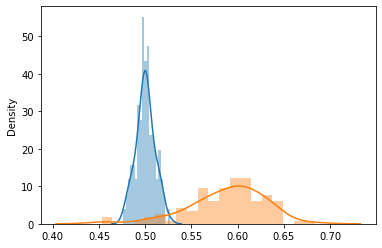

In [25]:
_=sns.distplot(bal_accs, bins=20)
_=sns.distplot(accs, bins=20)

/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/valentin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


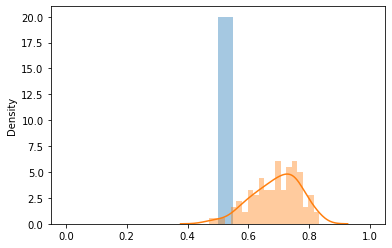

In [23]:
_=sns.distplot(bal_accs, bins=20)
_=sns.distplot(accs, bins=20)

---

# `statsmodels` baseline

In [11]:
import statsmodels.api as sm

pvals= []


for _ in tqdm(range(30)):
    words_shuffled = np.random.permutation(mldf.target.unique())

    ratio = int(mldf.target.unique().shape[0]*0.8)
    train_words = set(words_shuffled[:ratio])
    msk = mldf.target.isin(train_words)


    train_df = mldf[msk]
    test_df = mldf[~msk]


    target_train, anno_train, Y_train = (np.stack(train_df.target.apply(lambda w: scaled[mat_inds[w]])), 
                                             train_df.iloc[:, 5:].to_numpy(), 
                                             train_df.maj_vote.to_numpy())

    target_test, anno_test, Y_test = (np.stack(test_df.target.apply(lambda w: scaled[mat_inds[w]])),
                                            test_df.iloc[:, 5:].to_numpy(),
                                            test_df.maj_vote.to_numpy())

    target_train = np.zeros_like(target_train)


    X_train, X_test = np.hstack([target_train, anno_train]), np.hstack([target_test, anno_test])




    X = sm.add_constant(X_train)    

    results = sm.OLS(Y_train, X).fit()

    results.summary()
    
    pvals.append((results.pvalues[:100] < 0.05).sum())

100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


In [12]:
import scipy.stats as st

st.t.interval(0.95, len(pvals)-1, loc=np.mean(pvals), scale=st.sem(pvals))

(11.49193093488863, 21.97473573177804)

In [40]:
mldf.iloc[:, :5].to_csv("regression_df.csv")